In [9]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax.example_libraries.stax import Relu, LeakyRelu, Softplus, Tanh
import optax
from IPython import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:
from nn import RealNVP, make_transform
from loss import make_reinforce_loss

In [ ]:
batchsize = 8192
n = 6
dim = 2
beta = 10.0
nlayers = 2
rng = jax.random.PRNGKey(42)

transform = make_transform(16, Tanh)
flow_init = RealNVP(transform, nlayers)

init_rng, rng = jax.random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, n*dim)

In [12]:
loss = make_reinforce_loss(flow_inverse, n, dim, beta)
value_and_grad = jax.value_and_grad(loss, argnums=0, has_aux=True)

In [13]:
step_size = 1e-3
optimizer = optax.adam(step_size)
opt_state = optimizer.init(params)

In [14]:
@jax.jit
def step(rng, params, opt_state):
    batch_inputs = jax.random.normal(rng, (batchsize, n*dim))
    outputs, _ = flow_forward(params, batch_inputs)
    value, grad = value_and_grad(params, outputs)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return value, params, opt_state, outputs

In [15]:
# @jax.jit
def visualize_configuration(params):
    output, _ = flow_forward(params, jnp.zeros((1, n*dim)))
    output = output.reshape(n, dim)

    fig = plt.figure()
    ax = Axes3D(fig)

    ax.scatter(output[:, 0], output[:, 1], output[:, 2])

    plt.show()

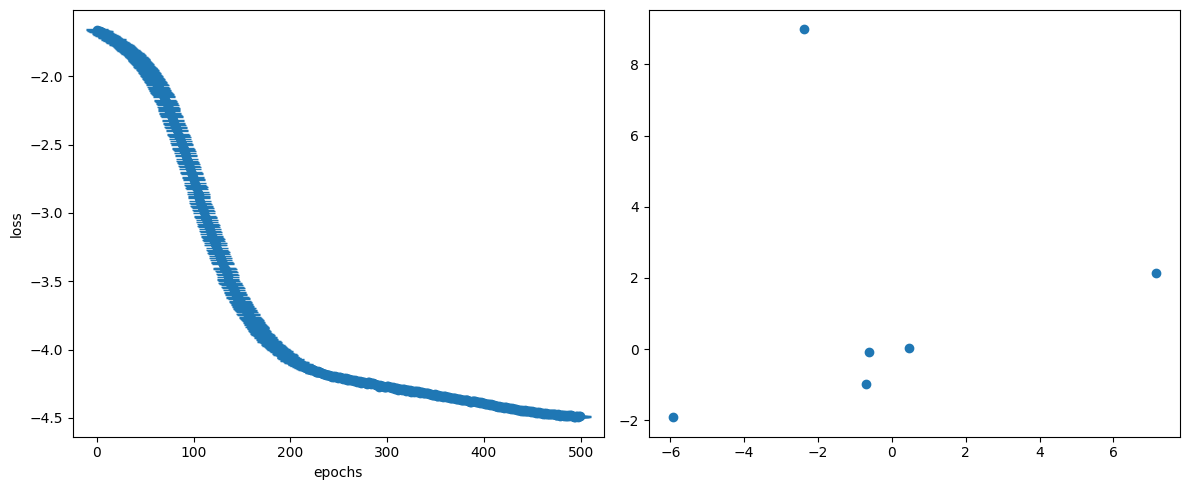

[Array(-4.48870308, dtype=float64), Array(0.00289937, dtype=float64)]


In [16]:
loss_history = []
nsteps = 500
for i in range(nsteps):
    step_rng, rng = jax.random.split(rng)
    value, params, opt_state, outputs = step(step_rng, params, opt_state)
    _, (f_mean, f_err) = value

    loss_history.append([f_mean, f_err])
    print(i, f_mean, f_err)

    display.clear_output(wait=True) 

    fig = plt.figure(figsize=(12,5))

    # 2D L-J visualization
    ax1 = fig.add_subplot(121)
    y = jnp.reshape(jnp.array(loss_history), (-1, 2))
    ax1.errorbar(jnp.arange(i+1), y[:, 0], yerr=y[:, 1], marker='o', capsize=8)
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')

    output, _ = flow_forward(params, jnp.zeros((1, n*dim)))
    output = output.reshape(n, dim)
    ax2 = fig.add_subplot(122)
    ax2.scatter(output[:, 0], output[:, 1])

    # ax1 = fig.add_subplot(221)
    # y = jnp.reshape(jnp.array(loss_history), (-1, 2))
    # ax1.errorbar(jnp.arange(i+1), y[:, 0], yerr=y[:, 1], marker='o', capsize=8)
    # ax1.set_xlabel('epochs')
    # ax1.set_ylabel('loss')

    # ax2 = fig.add_subplot(222, projection='3d') 
    # output, _ = flow_forward(params, jnp.zeros((1, n*dim)))
    # output = output.reshape(n, dim)
    # ax2.scatter(output[:, 0], output[:, 1], output[:, 2])
    # # for idx in range(n):
    #     # ax2.plot(output[:, 0], output[:, 1], output[:, 2])

    # ax3 = fig.add_subplot(223)
    # ax3.scatter(output[:, 0], output[:, 1])

    # ax4 = fig.add_subplot(224)
    # ax4.scatter(output[:, 0], output[:, 2])

    plt.tight_layout()

    plt.pause(0.01)
print(loss_history[-1])